# Weekly Cases + Deaths Model - Scaled


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from datetime import datetime, timedelta
import pymc3 as pm
from os import walk
from scipy.stats import lognorm
from scipy import stats as sps

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now().date() - timedelta(days=1)

In [3]:
(_, _, filenames) = next(walk('./RKI data'))
file_names = [name for name in filenames if name.startswith('RKI_COVID19')]
file_names.sort()
df_raw = pd.read_csv('./RKI data/' + file_names[-1], parse_dates=['Meldedatum', 'Refdatum'])
df_rki = df_raw.copy()
#df_rki['Meldedatum'] = pd.to_datetime(df_rki['Meldedatum'])
#df_rki['Refdatum'] = pd.to_datetime(df_rki['Refdatum'])
df_rki['week'] = df_rki['Meldedatum'].dt.week
df_rki = df_rki.query('Meldedatum > @start_date' 
              ' and Meldedatum <= @end_date')
df_rki['Meldeverzug'] = (df_rki['Meldedatum'] - df_rki['Refdatum']).dt.days

f"Found {df_rki['AnzahlFall'].sum():,} cases downloaded at {file_names[-1][12:26]}"

'Found 167,165 cases downloaded at 2020-05-08_09h'

In [4]:
df_rki[:3]

,Unnamed: 0,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,...,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,week,Meldeverzug
0,0,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,5410578,2020-03-14,...,"08.05.2020, 00:00 Uhr",0,-9,2020-03-16,0,1,1,Nicht übermittelt,11,-2
1,1,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,5410579,2020-03-19,...,"08.05.2020, 00:00 Uhr",0,-9,2020-03-13,0,1,1,Nicht übermittelt,12,6
2,2,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,5410580,2020-03-19,...,"08.05.2020, 00:00 Uhr",0,-9,2020-03-16,0,1,1,Nicht übermittelt,12,3


In [5]:
df_rki['Altersgruppe'].unique()

array(['A15-A34', 'A35-A59', 'A60-A79', 'A80+', 'A05-A14', 'A00-A04',
       'unbekannt'], dtype=object)

In [6]:
days_per_week = df_rki[['week', 'Meldedatum']].drop_duplicates()
weeks_ending = days_per_week.groupby('week')['Meldedatum'].max().reset_index()
weeks_ending.columns = ['week', 'last_dow']

n_days = days_per_week.groupby('week').size()
complete = n_days[n_days == 7]
min_complete_week = complete.index.min()
max_complete_week = complete.index.max()
min_complete_week, max_complete_week

(9, 18)

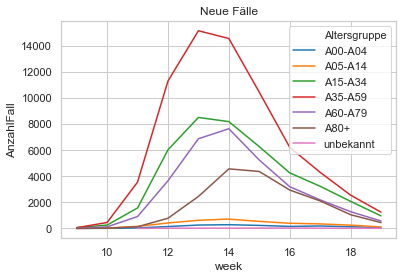

In [7]:
weekly_totals = df_rki.query('week >= @min_complete_week')\
                     .groupby(['week', 'Altersgruppe'])[['AnzahlFall']].sum()

sns.lineplot(x='week',y='AnzahlFall', hue='Altersgruppe', data=weekly_totals.reset_index())
plt.title('Neue Fälle');

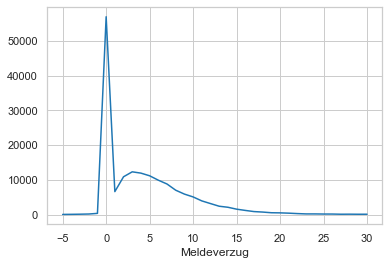

In [8]:
from matplotlib import ticker

case_weighted = df_rki.groupby('Meldeverzug')['AnzahlFall'].sum()
case_weighted.loc[-5:30].plot()

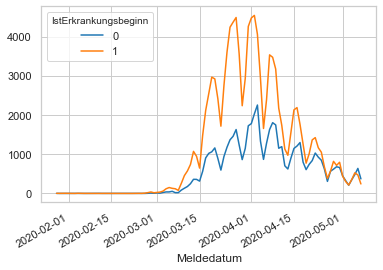

In [9]:
by_begin = df_rki.groupby(['Meldedatum', 'IstErkrankungsbeginn'])['AnzahlFall'].sum().reset_index()
by_begin = by_begin.pivot(index='Meldedatum', columns='IstErkrankungsbeginn', values='AnzahlFall').fillna(0)
by_begin.plot()

## Epidemilogical paramters

*Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data* Linton, Kobayashi, et al. 17th of Feb

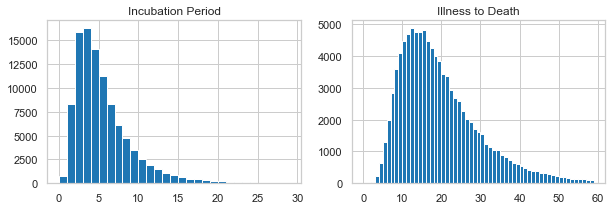

In [12]:
incubation = np.random.lognormal(1.525, .625, size=100000)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(incubation, bins=range(30))
axes[0].set_title('Incubation Period')
death = np.random.lognormal(2.865, .533, size=100000)
axes[1].hist(death, bins=range(60))
_= axes[1].set_title('Illness to Death')

In [13]:
# generation time
# Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing Ferretti, Fraser et al.

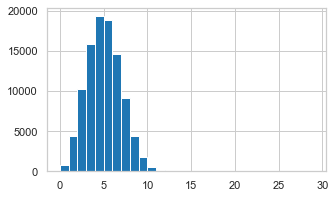

In [14]:
gen_time = np.random.weibull(2.826, size=100000) *  5.665
plt.figure(figsize=(5,3))
_= plt.hist(gen_time, bins=range(30))

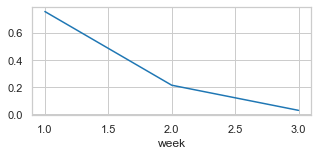

In [15]:
def lognorm_frame(mu, sigma):
    incubation_time = lognorm(s=sigma, scale=np.exp(mu))
    cdf = pd.Series(incubation_time.cdf(range(90)))
    daily_p = cdf - cdf.shift(1).fillna(0)
    return daily_p

cum_inc_time = lognorm_frame(1.525, 0.625)[:22]
cum_tt_death = lognorm_frame(2.865, 0.533)

# infection_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
# infection_to_death.plot(figsize=(5,2))
# plt.title('Infection to Death')
# plt.show()

def to_weekly_dist(dist):
    week_starts = np.array(range(0,len(dist) + 1, 7))
    cum_dist = dist.cumsum() / dist.sum()
    weekly = (cum_dist[week_starts] - cum_dist[week_starts].shift(1).fillna(0))
    weekly.index = (weekly.index / 7).astype(int)
    return weekly

weekly_incubation = to_weekly_dist(cum_inc_time)
weekly_incubation[1:].plot(figsize=(5,2))
_= plt.xlabel('week')

In [16]:
# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
mortality = pd.DataFrame({
    'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
    'mortality' : [0.0005, 0.003, 0.03, 0.078]
})

## Crude cases based on deaths

Dropped age groups: 


Altersgruppe
A00-A04      1
A05-A14      0
unbekannt   -1
Name: AnzahlTodesfall, dtype: int64

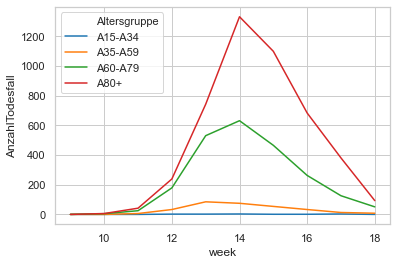

In [17]:
complete_weeks = df_rki.query('week >= @min_complete_week and week <= @max_complete_week')
deaths_by_age = complete_weeks.groupby(['week', 'Altersgruppe'])['AnzahlTodesfall'].sum().reset_index()
to_drop = deaths_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
print('Dropped age groups: ')
display(deaths_by_age[to_drop].groupby('Altersgruppe')['AnzahlTodesfall'].sum())
deaths_by_age['cartesian_key'] = True

deaths_by_age = deaths_by_age[~to_drop]
_= sns.lineplot(x='week', y='AnzahlTodesfall', hue='Altersgruppe', data=deaths_by_age)

In [18]:
# week_cutoff = 7

# # some people die early some die late in a give week, 
# # so they had between one a two weeks since the start of the last week
# offset_case_factors = (weekly_inf_death + weekly_inf_death.shift(-1).fillna(0)) / 2
# offset_case_factors = offset_case_factors[:week_cutoff + 1].to_frame().reset_index()
# offset_case_factors.columns = ['week_offset', 'infection_factor']
# offset_case_factors['cartesian_key'] = True
# offset_merge = deaths_by_age.merge(offset_case_factors)
# offset_merge['infected_week'] = offset_merge['week'] - offset_merge['week_offset']
# offset_merge['deadly_infected'] = offset_merge['AnzahlTodesfall'] * offset_merge['infection_factor']

# df_deadly_infection = offset_merge.groupby(['infected_week', 'Altersgruppe'])['deadly_infected'].sum().reset_index()

# df_deadly_infection = df_deadly_infection.merge(mortality)
# df_deadly_infection['infected'] = df_deadly_infection['deadly_infected'] / df_deadly_infection['mortality']
# df_deadly_infection = df_deadly_infection.query('infected_week <= @max_complete_week - @week_cutoff')
# df_deadly_infection = df_deadly_infection.merge(weeks_ending.reset_index(), left_on='infected_week', right_on='week')

# # https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
# mortality = pd.DataFrame({
#     'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
#     'mortality' : [0.0005, 0.003, 0.03, 0.078]
# })
# df_deadly_infection = df_deadly_infection.merge(mortality)
# df_deadly_infection['infected'] = df_deadly_infection['deadly_infected'] / df_deadly_infection['mortality']
# _= sns.lineplot(x='infected_week', y='infected', hue='Altersgruppe', data=df_deadly_infection)

### Reported cases

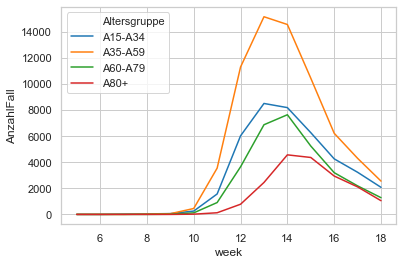

In [19]:
cases_by_age = df_rki.query('week <= @max_complete_week')\
                     .groupby(['Altersgruppe', 'week'])['AnzahlFall'].sum()\
                     .reset_index()
to_drop = cases_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
cases_by_age = cases_by_age[~to_drop]
sns.lineplot(x='week', y='AnzahlFall', hue='Altersgruppe', data=cases_by_age)

## Bayesian cases based on deaths

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185

Is $r(t)$ in the formula below correct or should it be 

$$ 
\text{new infections}(t) = \text{new infections}(t-1) \cdot e^{\gamma (r(t) -1)} \\
\text{new deaths}(t)  = \sum_{k=0}^\text{cutoff} \operatorname{Pois}(\text{new infections}(t -k) \cdot p_\text{death-delay}(k))
$$

In [20]:
age_group = 'A35-A59'

min_complete_week = deaths_by_age.query('Altersgruppe == @age_group and AnzahlTodesfall > 0')['week'].min()
# allow time for cases to lead to deaths at week min_complete_week
start_offset = 2
start_week = min_complete_week - start_offset
# deaths from last week might not be reported yet
death_end_week = max_complete_week - 5
n_death_weeks = death_end_week - start_week + 1
n_weeks = max_complete_week - start_week + 1
f'n_weeks: {n_weeks}, start_week: {start_week}, death_end_week: {death_end_week}, n_death_weeks: {n_death_weeks}'

'n_weeks: 10, start_week: 9, death_end_week: 13, n_death_weeks: 5'

In [21]:
# this lower triangular matirx vectorizes the multiplication with r,
# which is composed of a starting value r_zero and it's changes over
# the following time points
TRIL = []
for i in range(1, n_weeks):
    row = list(range(1, i+1))
    row.reverse()
    n_zeros = n_weeks - i - 1
    if n_zeros > 0:
        row = np.concatenate([row, np.zeros(n_zeros)])
    TRIL.append(row[:16])
TRIL = np.array(TRIL)
print(TRIL.shape)
TRIL[:3,:3]

(9, 9)


array([[1., 0., 0.],
       [2., 1., 0.],
       [3., 2., 1.]])

In [22]:
def create_delay_matrix(delay):
    def pad_delay_series(delay):
        if n_weeks > delay.shape[0]:
            padded_delay = np.concatenate([delay.values, 
                                           np.zeros(n_weeks - delay.shape[0])])
        else:
            padded_delay = delay.values[:n_weeks]
        padded_delay = pd.Series(padded_delay)
        return padded_delay
    padded_delay = pad_delay_series(delay)
    res = [padded_delay.shift(i).fillna(0).values for i in range(n_weeks)]
    return np.array(res).T

DD = create_delay_matrix(weekly_incubation)
# n_weeks, n_weeks
print(DD.shape)
DD[:3,:3]

(10, 10)


array([[0.        , 0.        , 0.        ],
       [0.75535453, 0.        , 0.        ],
       [0.21460865, 0.75535453, 0.        ]])

In [23]:
deaths = deaths_by_age.query('Altersgruppe == @age_group')
n_zeros = (n_weeks - len(deaths))
deaths = pd.concat([pd.Series([0] * n_zeros, 
                              index=range(start_week, start_week + n_zeros)), 
                    deaths.set_index('week')['AnzahlTodesfall']])
deaths.loc[min_complete_week:death_end_week]

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


11     6
12    33
13    85
dtype: int64

In [25]:
cases = cases_by_age.query('Altersgruppe == @age_group')
cases = cases.set_index('week')['AnzahlFall']
cases = pd.Series(cases, index=range(start_week, start_week + n_weeks)).fillna(0)
cases.loc[min_complete_week:]

from sklearn.preprocessing import RobustScaler
case_scaler = RobustScaler(with_centering=False)
scaled_cases = case_scaler.fit_transform(cases.values.reshape(-1,1))
scaled_cases = pd.Series(scaled_cases[:, 0], index=cases.index)
scaled_cases

9     0.006758
10    0.054905
11    0.428502
12    1.364306
13    1.829492
14    1.757693
15    1.260529
16    0.750935
17    0.519006
18    0.308314
dtype: float64

In [30]:
import theano

# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# in weeks
serial_interval = 1
group_mortality = mortality.set_index('Altersgruppe').loc[age_group].iloc[0]


with pm.Model() as model:
    r_zero = pm.Normal('r_zero', np.log(3), 0.5)
    # r_sigma = pm.Gamma('r_sigma', 10, 100)
    r_delta = pm.Normal('r_delta', 0, 0.5, shape=n_weeks-2)
    r = pm.Deterministic('r', pm.math.concatenate([r_zero.flatten(), r_delta]))
    # substract 1 from the first entry of r, 
    # which substracts 1 from all r as they are the sum of the entries
    
    # log_infection are modelled linearly with slope sum_0^t (r[t] - 1) 
    start_infections = np.array(-2)
    
    # TODO: add logit growth from SIR model, to keep the exp from exploding for high outliers <<<-----------!!!!!!!!!!!!!!!!!!!!!!!!!!!
    log_infection_following = start_infections + pm.math.dot(TRIL, r / serial_interval)
    all_log_infections = pm.math.concatenate([start_infections.flatten(), log_infection_following])
    log_infections = pm.Deterministic('log_infections', all_log_infections)
    
    # obs_infection = df_rki.query('Altersgruppe == @age_group and \
    #                          week >= @min_complete_week and \
    #                          week <= @max_complete_week').groupby('week')['AnzahlFall'].sum()
    # obs_infection
    #pm.Poisson('obs_infection', np.exp(log_indections), observed=obs_infection)
    
    # the death delay matrix DD spreads infections out into the future 
    # weighted by the time to death probability on a future day
    expected_cases = pm.Deterministic('expected_cases', pm.math.dot(DD, np.exp(log_infections)))
    
    #case_reporting_rate = pm.Beta('case_reporting_rate', mu=0.25, sigma=.1)
    # the week of the first infections we still don't have cases, because of the incubation period
    obs_cases = pm.Normal('obs_cases', 
                          expected_cases[1:],# * case_reporting_rate, 
                          sigma=expected_cases[1:] / 5,# * case_reporting_rate)), 
                          shape=n_weeks,
                          observed=scaled_cases[1:])
    
#     expected_deaths = pm.Deterministic('expected_deaths', expected_cases * group_mortality)
#     obs_deaths = pm.Normal('obs_deaths', 
#                             expected_deaths[start_offset:n_death_weeks],
#                             sigma=np.sqrt(expected_deaths[start_offset:n_death_weeks]),
#                             shape=n_weeks, 
#                             observed=deaths.loc[start_offset:death_end_week])

print(model.test_point)
model.check_test_point()  

{'r_zero': array(1.09861229), 'r_delta': array([0., 0., 0., 0., 0., 0., 0., 0.])}


r_zero       -0.23
r_delta      -1.81
obs_cases   -77.41
Name: Log-probability of test_point, dtype: float64

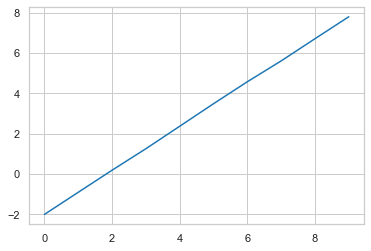

In [31]:
log_inf = pm.sample_prior_predictive(samples=10000, model=model, vars=['log_infections'])['log_infections']
plt.plot(np.median(log_inf, axis=0))

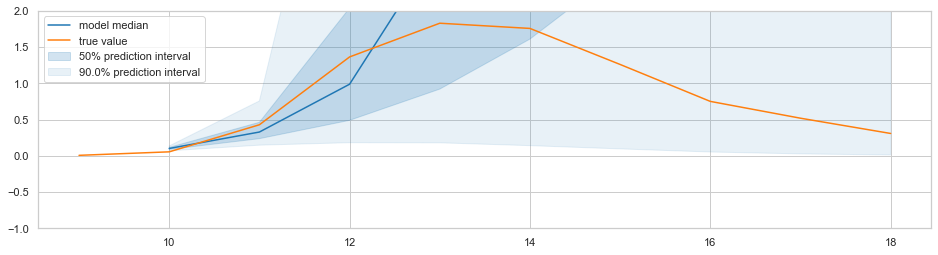

In [32]:
def plot_sample_with_quantiles(sample_values, offset, alpha=0.1):
    plot_with_q = pd.DataFrame(sample_values).apply(pd.Series.quantile, q=[alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2]).T
    plot_with_q.index = plot_with_q.index + offset
    plot_with_q[0.5].plot(label='model median')
    plt.fill_between(plot_with_q.index,
                     plot_with_q[0.25],
                     plot_with_q[0.75], 
                     alpha=0.2,
                     label=f'50% prediction interval',
                     color='C0')
    plt.fill_between(plot_with_q.index,
                     plot_with_q[alpha/2],
                     plot_with_q[1 - alpha/2], 
                     alpha=0.1,
                     label=f'{100 * (1 - alpha)}% prediction interval',
                     color='C0')

def sanity_check(true_values=None, obs_var_name='obs'):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=10000, model=model, vars=[obs_var_name])[obs_var_name]
    plt.figure(figsize=(16, 4))
    plot_sample_with_quantiles(y, start_week + 1)
    true_values.plot(label='true value')
    plt.ylim([-1, 2])
    plt.legend(loc='upper left')
    return y
    

# And run the sanity check
y = sanity_check(scaled_cases, 'obs_cases')

In [33]:
with model:
    #print(model.test_point)
    trace = pm.sample(step_scale=0.05, tune=1000)
    #trace = pm.sample(10000, tune=5000, step=pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_delta, r_zero]
Sampling 4 chains, 3 divergences: 100%|██████████| 6000/6000 [00:27<00:00, 220.16draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


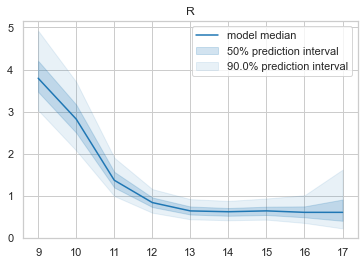

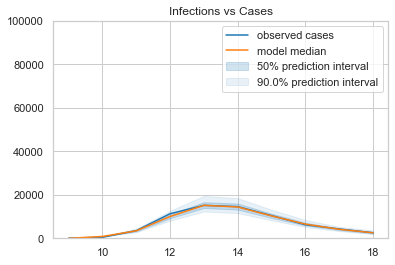

KeyError: 'Unknown variable expected_deaths'

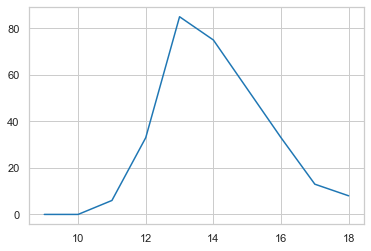

In [35]:
r_eff = np.exp(np.cumsum(trace['r'], axis=1))
plot_sample_with_quantiles(r_eff, start_week)
plt.title('R')
plt.legend()
plt.show()

cases.plot(label='observed cases')
plot_sample_with_quantiles(case_scaler.inverse_transform(trace['expected_cases']), start_week)
plt.legend()
plt.ylim([0, 1e5])
plt.title('Infections vs Cases')
plt.show()

pd.Series(deaths).plot(label='observed deaths')
plot_sample_with_quantiles(trace['expected_deaths'], start_week)
plt.legend()
plt.title('Deaths');

In [188]:
np.median(np.exp(trace['log_infections']), axis=0)

array([1.64872127e+00, 4.48168907e+00, 1.21824940e+01, 3.31154520e+01,
       9.00171313e+01, 2.44691932e+02, 6.65141633e+02, 1.80804241e+03,
       4.91476884e+03, 1.33597268e+04, 3.63155027e+04])

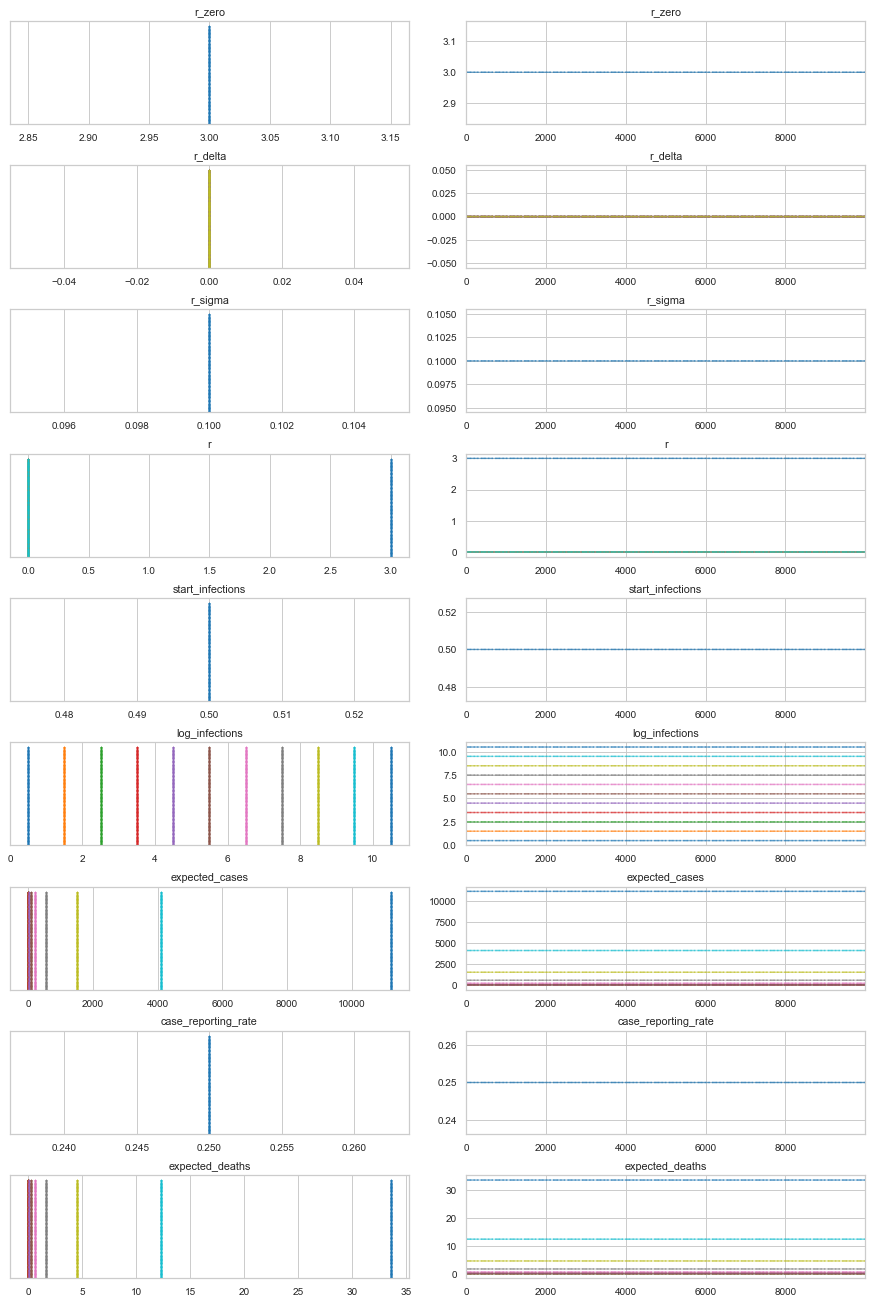

In [189]:
_ = pm.traceplot(trace)

In [366]:
posterior = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 2000/2000 [00:03<00:00, 599.01it/s]


In [367]:

    
rescaled = (pd.DataFrame(posterior['obs']) * case_range  + df_input[:data_end]['New Cases'].min())
model_with_quantiles(rescaled, 0.05, list((change_points[1:] * n_days).astype(int)))

plt.plot((df_input[:data_end]['New Cases'].values), label='Johns Hopkins')
plt.legend()
# plt.yscale('log')

KeyError: 'obs'

## Distribution Playground

0.0183616872811975 0.14902068283374822


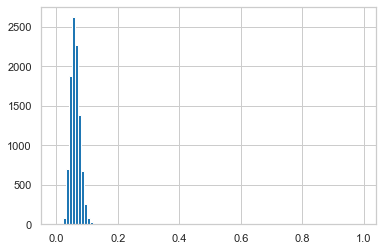

In [451]:
with pm.Model():
    a = pm.Gamma('a', 15, 250).random(size=10000)
    pd.Series(a).hist(bins=np.arange(0, 1, 0.01))
    print(a.min(), a.max())

In [620]:
a.min()

999999994448501504